# Discovery Analytics

Discovery is all about finding previously unknown anomalies or patterns in your data. This can be **clustering**, looking for **trends**, using **regression** to find relationships between variables, etc. In this exercise we will try our hand at clustering the data to look for user or workstation groups, some simple regression to see if in increased number of total flows is related to the number of unique ASs accessed in a day, and finally look for trends in the time series.
- - -

We'll start with some basic import statements and readability settings and retreive our data.


In [96]:
import pandas as pd
from pandas import DataFrame as df
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pprint import pprint

# formatting 
pd.set_option("max_rows", 15)

# read in our test data
dta = pd.read_csv("data/network_traffic.csv")

#display our DataFrame
dta

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1
5,2006-07-01,0,3320,1
6,2006-07-01,0,3561,13
...,...,...,...,...
20796,2006-09-30,8,33322,1
20797,2006-09-30,8,35845,1


### Quick review: 
Look at the ouput below and see if you remember how to ensure our data types are correct

In [97]:
dta.describe()

,l_ipn,r_asn,f
count,20803.000000,20803.000000,20803.000000
mean,4.228236,12138.320338,93.914243
std,3.278183,9766.324252,5764.995269
min,0.000000,3.000000,1.000000
25%,1.000000,4323.000000,1.000000
50%,4.000000,8764.000000,2.000000
75%,7.000000,17676.000000,8.000000
max,9.000000,40092.000000,784234.000000


In [98]:
#Put your code here to make our categorical variables categorical

In [99]:
# %load solutions/fix_types.py
dta.l_ipn = dta.l_ipn.astype('category')
dta.r_asn = dta.r_asn.astype('category')
dta.describe(include='all')

,date,l_ipn,r_asn,f
count,20803,20803.0,20803.0,20803.000000
unique,92,10.0,2005.0,NaN
top,2006-07-26,0.0,3561.0,NaN
freq,372,3980.0,483.0,NaN
mean,NaN,NaN,NaN,93.914243
std,NaN,NaN,NaN,5764.995269
min,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,2.000000
75%,NaN,NaN,NaN,8.000000


In [100]:
dta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20803 entries, 0 to 20802
Data columns (total 4 columns):
date     20803 non-null object
l_ipn    20803 non-null category
r_asn    20803 non-null category
f        20803 non-null int64
dtypes: category(2), int64(1), object(1)
memory usage: 482.1+ KB


Now that we have our data cleaned up a little and see that we have no Null values (bonus!), let's think about how to procede. We saw before that there is some interesting data in the `f` field. From our summary we see that the three bottom quartiles contain data from 0 to 8, but our max value is amost 800,000!

We can take a couple approaches to see where these large values are coming from. They might be the work of one or two computers, it may have been a couple anomalous days, and it may be tied to certain autonomous systems. Let's compare the `f` field by host (IP Address)

In [101]:
#We'll use groupby again and look at the data
dta.groupby('l_ipn').describe()

f                                                          
        count        mean           std  min  25%  50%    75%       max
l_ipn                                                                  
0      3980.0   26.426382    232.733282  1.0  1.0  1.0   2.00    5059.0
1      2159.0   90.639648    466.006782  1.0  1.0  2.0   5.00    4718.0
2      2416.0   81.007036    299.501027  1.0  2.0  6.0  47.25    5214.0
3      1186.0    4.134907     16.190804  1.0  1.0  2.0   2.00     313.0
4      1308.0  898.636850  22963.981816  1.0  1.0  4.0  30.00  784234.0
5      1249.0    4.627702     15.580845  1.0  1.0  2.0   4.00     322.0
6      1305.0    5.114176     23.323676  1.0  1.0  2.0   3.00     530.0
7      2233.0   15.836095     41.948103  1.0  2.0  4.0  13.00    1057.0
8      2230.0   53.902691    341.605457  1.0  2.0  4.0   9.00    7902.0
9      2737.0   39.743149    108.232832  1.0  2.0  6.0  21.00    1027.0

We'll make a note that IP 4 has some very different behavior compared to the rest (not necessarily malicious). Let's see if there is any way to meaningfully group these IPs.
_ _ _ 
I'd like to visualize this data to look for anything that jumps out to me for grouping purposes. One thing we can do is compare the number of unique ASs accessed by an IP and the total number of flows. 

In [102]:
#this returns a Series object with the number of unique ASs by IP
dta.groupby('l_ipn').r_asn.describe()['unique']

l_ipn
0    935
1    631
2    403
3    476
4    382
5    418
6    496
7    466
8    582
9    514
Name: unique, dtype: int64

In [103]:
#this returns a Series with the sum of flows per IP
dta.groupby('l_ipn').f.sum()

l_ipn
0     105177
1     195691
2     195713
3       4904
4    1175417
5       5780
6       6674
7      35362
8     120203
9     108777
Name: f, dtype: int64

In [104]:
# we'll make two Series for our unique count and total flows
asns = dta.groupby('l_ipn').r_asn.describe()['unique']
flows = dta.groupby('l_ipn').f.sum()
# now we'll make a new DataFrame with the two lists together
dataf = df({'asns':asns, 'flows':flows}, index = flows.index)
dataf

,asns,flows
l_ipn,,
0,935,105177
1,631,195691
2,403,195713
3,476,4904
4,382,1175417
5,418,5780
6,496,6674
7,466,35362
8,582,120203


In [105]:
dataf.describe(include='all')

,asns,flows
count,10.000000,1.000000e+01
mean,530.300000,1.953698e+05
std,161.908788,3.520110e+05
min,382.000000,4.904000e+03
25%,430.000000,1.384600e+04
50%,486.000000,1.069770e+05
75%,565.000000,1.768190e+05
max,935.000000,1.175417e+06


With this new DataFrame, we can plot the data and visually check for groups:

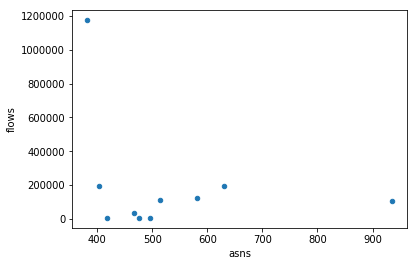

In [138]:
dataf.plot.scatter('asns', 'flows')

From the plot above, we can see a couple of possible anomalies to dig into. Let's add a little more detal to see the plot better and know where to look:

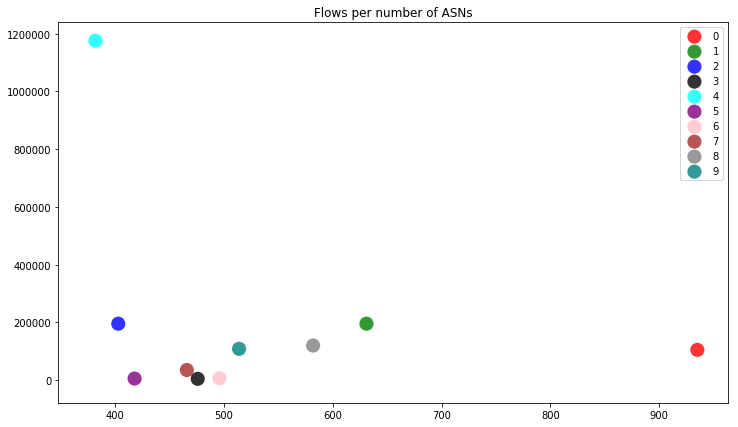

In [136]:
# some pre-processing for the plot
data = zip(dataf.asns, dataf.flows)
colors = ("red", "green", "blue", "black", "aqua", "purple", "pink", "brown", "gray", "teal")
ips = dataf.index
 
# Create plot using matplotlib instead of Pandas
fig = plt.figure(figsize=[12, 7])
ax = fig.add_subplot(1, 1, 1)
 
for data, color, ip in zip(data, colors, ips):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=200, label=ip)
 
plt.title('Flows per number of ASNs')
plt.legend()
plt.show()

It looks like most of the datapoints follow a roughly straight line indicating that there may be a positive correlation between the two variables. The interesting-looking points are the IPs 0, 2, and 4.

There is arguably a lot of aggregation happening here, we really have more granular data we could look at. What if we plot the number of unique number of asns accessed against flows, but treated each day as an individual data point?

In [142]:
asns = dta.groupby(['date', 'l_ipn']).r_asn.describe()['unique']
asns

date        l_ipn
2006-07-01  0        35
            1        19
            2        15
            3         9
            4        11
            5        12
            6        11
                     ..
2006-09-29  9         3
2006-09-30  0        38
            2        62
            4        19
            7         6
            8        84
            9         3
Name: unique, Length: 847, dtype: int64

In [143]:
flows = dta.groupby(['date', 'l_ipn']).f.sum()
flows

date        l_ipn
2006-07-01  0         106
            1         640
            2        1677
            3          22
            4         184
            5          44
            6          63
                     ... 
2006-09-29  9           5
2006-09-30  0        3264
            2        5560
            4        3169
            7         106
            8        3382
            9           4
Name: f, Length: 847, dtype: int64

In [144]:
newf = df({'asns':asns, 'flows':flows}, index=flows.index)
newf

asns  flows
date       l_ipn             
2006-07-01 0        35    106
           1        19    640
           2        15   1677
           3         9     22
           4        11    184
           5        12     44
           6        11     63
...                ...    ...
2006-09-29 9         3      5
2006-09-30 0        38   3264
           2        62   5560
           4        19   3169
           7         6    106
           8        84   3382
           9         3      4

[847 rows x 2 columns]

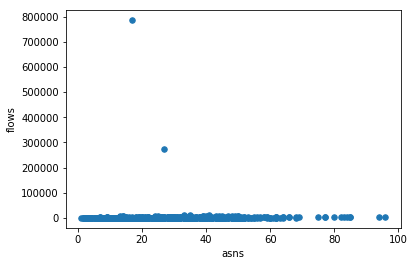

In [148]:
newf.plot.scatter('asns', 'flows', s=30)

In [150]:
newf.where(newf['flows']>100000)

asns  flows
date       l_ipn             
2006-07-01 0       NaN    NaN
           1       NaN    NaN
           2       NaN    NaN
           3       NaN    NaN
           4       NaN    NaN
           5       NaN    NaN
           6       NaN    NaN
...                ...    ...
2006-09-29 9       NaN    NaN
2006-09-30 0       NaN    NaN
           2       NaN    NaN
           4       NaN    NaN
           7       NaN    NaN
           8       NaN    NaN
           9       NaN    NaN

[847 rows x 2 columns]

In [139]:
# we'll make two Series for our unique count and total flows
asns = dta.groupby(['l_ipn', 'date').r_asn.describe()['unique']
flows = dta.groupby('l_ipn', 'date').f.sum()
# now we'll make a new DataFrame with the two lists together
dataf = df({'asns':asns, 'flows':flows}, index = flows.index)
dataf

ValueError: No axis named date for object type <class 'pandas.core.frame.DataFrame'>

In [33]:
dta.groupby('l_ipn').r_asn.describe()

,count,unique,top,freq
l_ipn,,,,
0,3980,935,13462,92
1,2159,631,4134,55
2,2416,403,1312,92
3,1186,476,4134,74
4,1308,382,31976,82
5,1249,418,8070,64
6,1305,496,4134,79
7,2233,466,18924,92
8,2230,582,15169,92


In [40]:
# create a list
ary = []

# populate the list with separate dataFrames for each IP
for i in range(10):
    ary.append(dta[dta['l_ipn'] == i])

In [41]:
# describe the data for IP: 0
ary[0].describe()

,l_ipn,r_asn,f
count,3980.0,3980.000000,3980.000000
mean,0.0,11890.358040,26.426382
std,0.0,9104.685237,232.733282
min,0.0,4.000000,1.000000
25%,0.0,4808.000000,1.000000
50%,0.0,8708.000000,1.000000
75%,0.0,17228.000000,2.000000
max,0.0,39834.000000,5059.000000


In [46]:
stds = []
for frame in ary:
    stds.append(frame.f.std())

stds1 = pd.DataFrame(stds)
stds1.describe()

,0
count,10.000000
mean,2450.910462
std,7209.307911
min,15.580845
25%,27.979783
50%,170.483057
75%,331.079349
max,22963.981816
